##### Import the libraries

In [3]:
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.datasets import imdb
from keras.utils import pad_sequences

##### Define the transformer block

In [6]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        # embed_dim: This parameter specifies the dimensionality of the input and output embeddings.
        # num_heads: This parameter controls the number of attention heads in the multi-head attention layer.
        # ff_dim: This parameter specifies the dimensionality of the feedforward network.
        # rate: This parameter controls the dropout rate, which is used to regularize the network and prevent overfitting.

        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # This creates a MultiHeadAttention layer, responsible for learning long-range dependencies within sequences.
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        # self.ffn: This creates a feedforward network, often used for additional nonlinear transformations.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # self.layernorm1 and self.layernorm2: These create LayerNormalization layers, which help stabilize training and improve convergence.
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        # self.dropout1 and self.dropout2: These create Dropout layers, randomly setting a portion of inputs to zero during training to prevent overfitting.

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        # Applies multi-head attention to the input sequence, allowing different parts of the sequence to interact with each other.
        attn_output = self.dropout1(attn_output, training=training)
        # Applies dropout to the attention output.
        out1 = self.layernorm1(inputs + attn_output)
        # Adds the attention output to the original input and applies layer normalization. This residual connection helps prevent vanishing gradients and improves training stability.
        ffn_output = self.ffn(out1)
        # Passes the normalized output through the feedforward network.
        ffn_output = self.dropout2(ffn_output, training=training)
        # Applies dropout to the feedforward output.
        return self.layernorm2(out1 + ffn_output)
        # Adds the feedforward output to the previous layer's output and applies final layer normalization before returning the result.

In [9]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        # maxlen: The maximum length of the input sequences the model will handle.
        # vocab_size: The total number of unique tokens (words) in the vocabulary.
        # embed_dim: The dimensionality of the embeddings 
            # (how each token and its position will be represented as a vector).
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # An Embedding layer that maps each token in the input sequence
        # to a dense vector of size embed_dim.
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
        # An Embedding layer that maps each position in the sequence
        # (from 0 to maxlen-1) to a dense vector of size embed_dim.

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # Extracts the actual length of the current input sequence.
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Creates a tensor of positions from 0 to maxlen-1.
        positions = self.pos_emb(positions)
        # Looks up the position embeddings for each position in the sequence.
        x = self.token_emb(x)
        # Looks up the token embeddings for each token in the input sequence.
        return x + positions
        # Adds the token embeddings and position embeddings element-wise,
        # resulting in a combined representation that captures both word
        # meaning and positional information.

In [10]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

In [11]:
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

17464789/17464789 [==============================] - 3s 0us/step
25000 Training sequences
25000 Validation sequences


In [12]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [13]:
x_train.shape

(25000, 200)

In [14]:
x_train[4000]

array([   89,     8,   511,  6339,    59,  2013,    41,   523,   147,
        1876,     5, 18733,   175,   347,    11,   618,     4,   172,
          96,  2329,     2,     9,   862,  4722,     8,    41,     5,
          27,   532,  2904,     9,  5750,     4,  9910,   136,  7900,
        9287,     5,     2,    19,  1456,   921,    42,  2475,  1488,
          68,  2456,   216,    17,     6,  2143,    48,    13,    69,
           6, 12928,    13,    62,    28,  2564,    12,     8,    98,
         634,   908,    10,    10,  2047,  3423,     9, 14790,    17,
           2,     6,    87,  1465,    48,    25,   377,    27,   478,
         157,    11,     2, 18497,    29,  2010,     4,  2915,     7,
        5712, 12710,    83,     6,  3207,     2,     7,   107,    42,
         289,   715,   257,     5,    95,  9727,     4, 13331,    11,
          17, 10846,     5, 13869,  1377,    17,   614,    11,    14,
         365,  1652,     2,     2,   373,    10,    10,     4,   167,
        6184,     2,

##### Combine all-together

In [15]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 32)           646400    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 200, 32)           10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

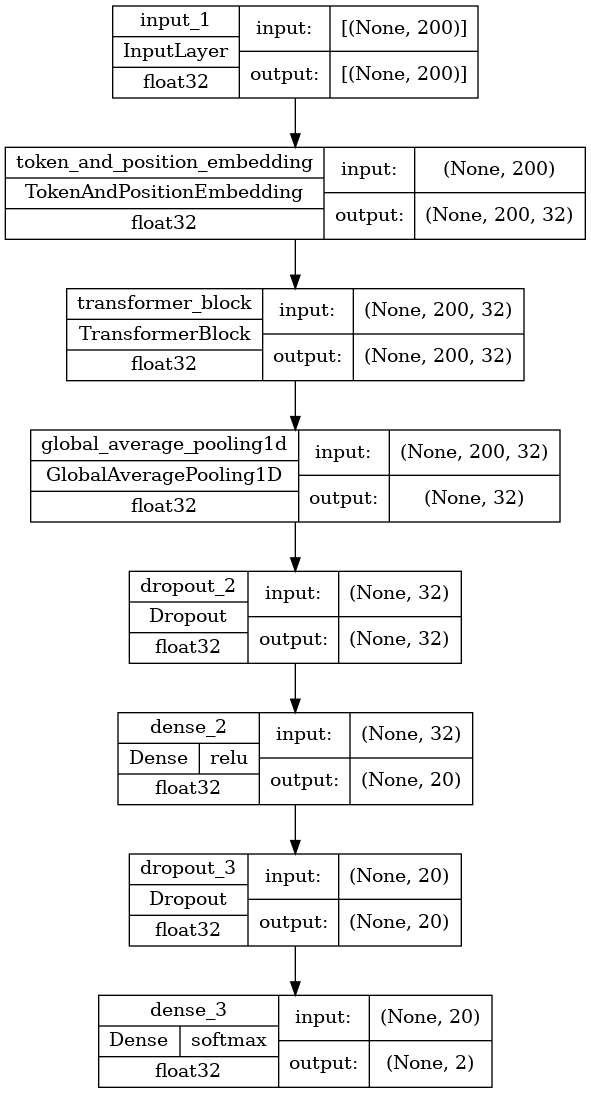

In [19]:
from keras.utils import plot_model
plot_model(model, show_dtype=True, show_layer_activations=True,
          show_layer_names=True, show_shapes=True)

##### Compile the model

In [21]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

##### Train the model

In [24]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, 
                    validation_data=(x_val, y_val))

Epoch 1/10
782/782 [==============================] - 48s 60ms/step - loss: 0.3983 - accuracy: 0.8013 - val_loss: 0.2950 - val_accuracy: 0.8676
Epoch 2/10
782/782 [==============================] - 46s 59ms/step - loss: 0.2021 - accuracy: 0.9214 - val_loss: 0.3168 - val_accuracy: 0.8722
Epoch 3/10
782/782 [==============================] - 46s 59ms/step - loss: 0.1320 - accuracy: 0.9518 - val_loss: 0.3785 - val_accuracy: 0.8614
Epoch 4/10
782/782 [==============================] - 46s 59ms/step - loss: 0.0828 - accuracy: 0.9726 - val_loss: 0.5053 - val_accuracy: 0.8498
Epoch 5/10
782/782 [==============================] - 47s 60ms/step - loss: 0.0571 - accuracy: 0.9818 - val_loss: 0.6562 - val_accuracy: 0.8338
Epoch 6/10
782/782 [==============================] - 47s 60ms/step - loss: 0.0422 - accuracy: 0.9877 - val_loss: 0.6075 - val_accuracy: 0.8430
Epoch 7/10
782/782 [==============================] - 46s 59ms/step - loss: 0.0327 - accuracy: 0.9907 - val_loss: 0.5927 - val_accuracy:

##### Predict on the unseen data